# Setup and Imports

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style
plt.style.use("ggplot")
sns.set(font_scale=1.1)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
# For consistent randomness if needed
np.random.seed(42)

# Load Datasets

In [59]:
# Load internal data
internal_df_flows = pd.read_csv("../data/daily_flow_table.csv", parse_dates=["date"])

# Load perturbed Morningstar data
morningstar_df_flows = pd.read_csv("../data/morningstar_flow_table_perturbed.csv", parse_dates=["date"])

# Load perturbed Bloomberg data
bloomberg_df_flows = pd.read_csv("../data/bloomberg_flow_table_perturbed.csv", parse_dates=["date"])

# Preview
internal_df_flows.head(2), morningstar_df_flows.head(2), bloomberg_df_flows.head(2)

(  ticker_id    asset_name asset_type   provider       date      inflow     outflow    net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  4753571.53  3659969.71  1093601.82  161.96
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02   779972.60   290418.06   489554.54  162.06,
   ticker_id    asset_name asset_type   provider       date       inflow     outflow    net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  11902784.57  4155114.78  7747669.79  161.96
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02   2272582.03  1589703.20   682878.83  162.06,
   ticker_id    asset_name asset_type   provider       date      inflow     outflow   net_flow     nav
 0       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-01  6918692.33  6401157.75  517534.58  161.96
 1       SPY  SPDR S&P 500        ETF  BlackRock 2024-01-02  3645319.86  2660565.26  984754.60  162.06)

# Clean and Rename Columns

In [60]:
# Columns to keep
cols = ["ticker_id", "provider", "date", "inflow", "outflow", "net_flow"]

# Clean & rename internal
internal_df_flows = internal_df_flows[cols].rename(columns={
    "inflow": "inflow_internal",
    "outflow": "outflow_internal",
    "net_flow": "net_flow_internal"
})

# Clean & rename Morningstar
morningstar_df_flows = morningstar_df_flows[cols].rename(columns={
    "inflow": "inflow_mstar",
    "outflow": "outflow_mstar",
    "net_flow": "net_flow_mstar"
})

# Clean & rename Bloomberg
bloomberg_df_flows = bloomberg_df_flows[cols].rename(columns={
    "inflow": "inflow_bbg",
    "outflow": "outflow_bbg",
    "net_flow": "net_flow_bbg"
})

# Preview internal
internal_df_flows.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal
0,SPY,BlackRock,2024-01-01,4753571.53,3659969.71,1093601.82
1,SPY,BlackRock,2024-01-02,779972.60,290418.06,489554.54
2,SPY,BlackRock,2024-01-03,4330880.73,3005575.06,1325305.67
3,SPY,BlackRock,2024-01-04,917022.55,1521211.21,-604188.66
4,SPY,BlackRock,2024-01-05,2623782.16,2159725.09,464057.07


# Merge All Three Datasets

In [61]:
# Merge internal and Morningstar first
merged_df = pd.merge(
    internal_df_flows,
    morningstar_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Merge in Bloomberg data
merged_df = pd.merge(
    merged_df,
    bloomberg_df_flows,
    on=["ticker_id", "provider", "date"],
    how="inner"
)

# Preview merged data
merged_df.head()

,ticker_id,provider,date,inflow_internal,outflow_internal,net_flow_internal,inflow_mstar,outflow_mstar,net_flow_mstar,inflow_bbg,outflow_bbg,net_flow_bbg
0,SPY,BlackRock,2024-01-01,4753571.53,3659969.71,1093601.82,11902784.57,4155114.78,7747669.79,6918692.33,6401157.75,517534.58
1,SPY,BlackRock,2024-01-02,779972.60,290418.06,489554.54,2272582.03,1589703.20,682878.83,3645319.86,2660565.26,984754.60
2,SPY,BlackRock,2024-01-03,4330880.73,3005575.06,1325305.67,5941222.65,4504298.31,1436924.34,4862291.63,3170691.04,1691600.59
3,SPY,BlackRock,2024-01-04,917022.55,1521211.21,-604188.66,1861701.12,2663434.89,-801733.77,2415634.82,2728722.10,-313087.28
4,SPY,BlackRock,2024-01-05,2623782.16,2159725.09,464057.07,10253365.26,3792205.02,6461160.24,3843328.86,7761229.19,-3917900.33


# Compute Discrepancies

In [62]:
for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        col_internal = f"{metric}_internal"
        col_source = f"{metric}_{source}"
        
        # Absolute difference
        merged_df[f"{metric}_abs_diff_{source}"] = (merged_df[col_internal] - merged_df[col_source]).abs().round(2)
        
        # Relative difference (avoid divide-by-zero)
        merged_df[f"{metric}_rel_diff_{source}"] = np.where(
            merged_df[col_internal] != 0,
            (merged_df[col_internal] - merged_df[col_source]).abs() / merged_df[col_internal],
            np.nan
        ).round(4)

# Preview
merged_df.filter(like="diff").head()

,inflow_abs_diff_mstar,inflow_rel_diff_mstar,outflow_abs_diff_mstar,outflow_rel_diff_mstar,net_flow_abs_diff_mstar,net_flow_rel_diff_mstar,inflow_abs_diff_bbg,inflow_rel_diff_bbg,outflow_abs_diff_bbg,outflow_rel_diff_bbg,net_flow_abs_diff_bbg,net_flow_rel_diff_bbg
0,7149213.04,1.5040,495145.07,0.1353,6654067.97,6.0845,2165120.80,0.4555,2741188.04,0.7490,576067.24,0.5268
1,1492609.43,1.9137,1299285.14,4.4738,193324.29,0.3949,2865347.26,3.6737,2370147.20,8.1612,495200.06,1.0115
2,1610341.92,0.3718,1498723.25,0.4986,111618.67,0.0842,531410.90,0.1227,165115.98,0.0549,366294.92,0.2764
3,944678.57,1.0302,1142223.68,0.7509,197545.11,-0.3270,1498612.27,1.6342,1207510.89,0.7938,291101.38,-0.4818
4,7629583.10,2.9079,1632479.93,0.7559,5997103.17,12.9232,1219546.70,0.4648,5601504.10,2.5936,4381957.40,9.4427


# Statistics

## Skewness and Kurtois

In [63]:
from scipy.stats import skew, kurtosis

skew_val = skew(merged_df["net_flow_rel_diff_mstar"].dropna())
kurt_val = kurtosis(merged_df["net_flow_rel_diff_mstar"].dropna(), fisher=False)

## RMSE/MAE

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"], squared=False)
mae = mean_absolute_error(merged_df["net_flow_internal"], merged_df["net_flow_mstar"])

c:\Users\Scott\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Summary

In [65]:
summary_stats = []

for source in ["mstar", "bbg"]:
    for metric in ["inflow", "outflow", "net_flow"]:
        abs_col = f"{metric}_abs_diff_{source}"
        rel_col = f"{metric}_rel_diff_{source}"
        
        summary_stats.append({
            "source": source,
            "metric": metric,
            "abs_mean": merged_df[abs_col].mean().round(2),
            "abs_median": merged_df[abs_col].median().round(2),
            "abs_std": merged_df[abs_col].std().round(2),
            "rel_mean": merged_df[rel_col].mean().round(4),
            "rel_median": merged_df[rel_col].median().round(4),
            "rel_std": merged_df[rel_col].std().round(4),
            "rel_skew": skew(merged_df[rel_col].dropna()).round(4),
            "rel_kurt": kurtosis(merged_df[rel_col].dropna(), fisher=False).round(4),
            "rmse": np.round(rmse, 2) if metric == "net_flow" else np.nan,
            "mae": np.round(mae, 2) if metric == "net_flow" else np.nan
        })

# Convert to DataFrame
discrepancy_summary = pd.DataFrame(summary_stats)

# Display
discrepancy_summary

,source,metric,abs_mean,abs_median,abs_std,rel_mean,rel_median,rel_std,rel_skew,rel_kurt,rmse,mae
0,mstar,inflow,3001149.69,2527599.10,2115903.55,8.4036,1.1147,307.2548,112.1998,14351.3507,NaN,NaN
1,mstar,outflow,2501599.56,2178145.24,1579670.19,10.5668,0.9498,638.0836,127.7325,17599.4474,NaN,NaN
2,mstar,net_flow,2011810.06,1530504.54,1794880.21,-2.6332,0.0030,432.5321,-198.0996,43339.9748,2696092.36,2011810.06
3,bbg,inflow,3509842.57,2991023.39,2374609.54,9.0580,1.3119,234.7442,83.4510,8383.7206,NaN,NaN
4,bbg,outflow,2973600.84,2615279.97,1802356.21,11.4309,1.1462,811.7479,178.7803,35066.8154,NaN,NaN
5,bbg,net_flow,2270881.63,1732894.36,2004415.39,-4.1899,0.0032,833.6332,-224.1381,51214.6142,2696092.36,2011810.06


# Visualizations

## KDE plots for relative differences

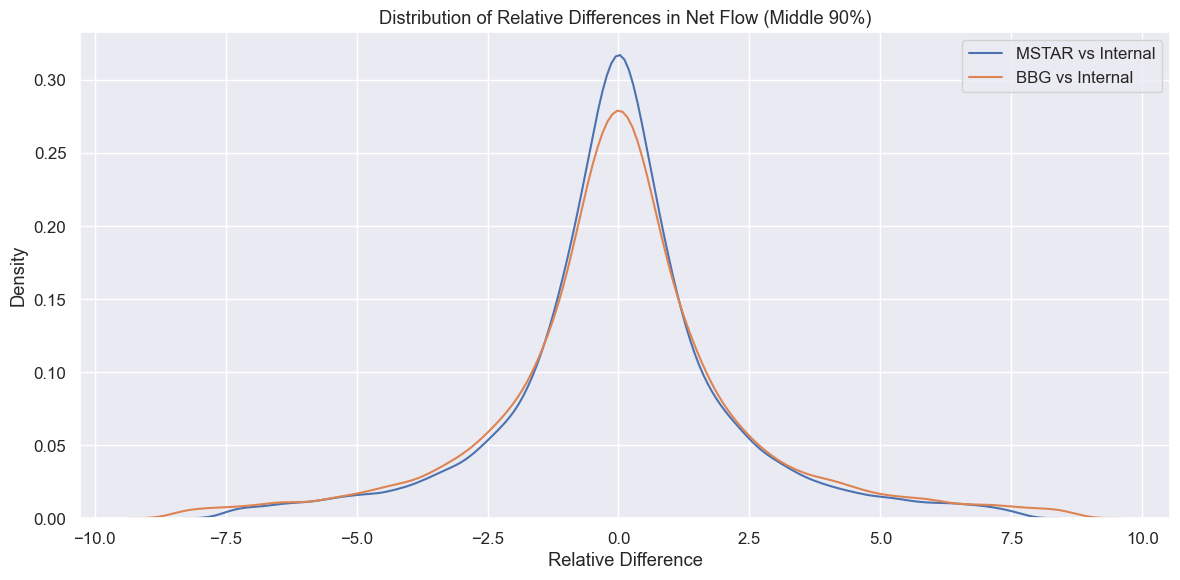

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KDE plots for relative differences
plt.figure(figsize=(12, 6))
for source in ["mstar", "bbg"]:
    rel_diff_col = f"net_flow_rel_diff_{source}"
    filtered_data = merged_df[(merged_df[rel_diff_col] >= merged_df[rel_diff_col].quantile(0.05)) & 
                              (merged_df[rel_diff_col] <= merged_df[rel_diff_col].quantile(0.95))]
    sns.kdeplot(
        data=filtered_data,
        x=rel_diff_col,
        label=f"{source.upper()} vs Internal"
    )
plt.title("Distribution of Relative Differences in Net Flow (Middle 90%)")
plt.xlabel("Relative Difference")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## Bar plot of mean relative differences

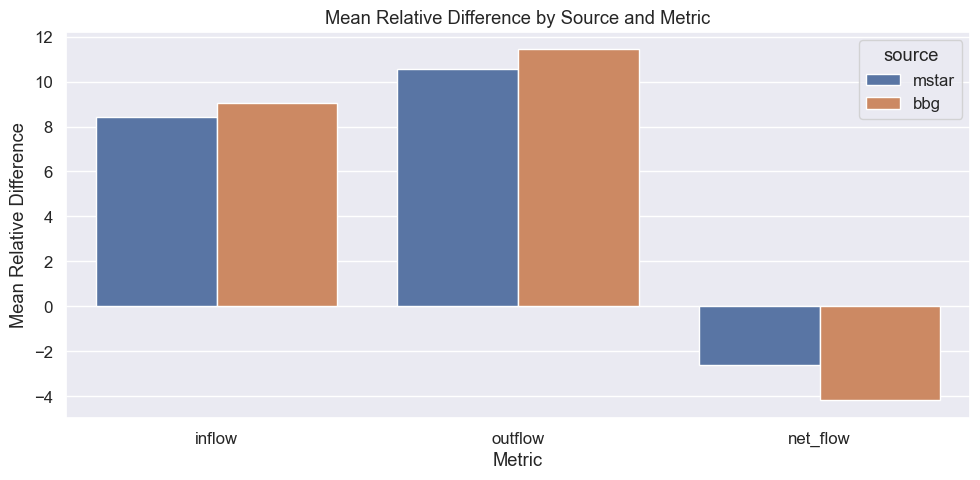

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    data=discrepancy_summary,
    x="metric",
    y="rel_mean",
    hue="source"
)
plt.title("Mean Relative Difference by Source and Metric")
plt.ylabel("Mean Relative Difference")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

## Box Plot of Relative Differences

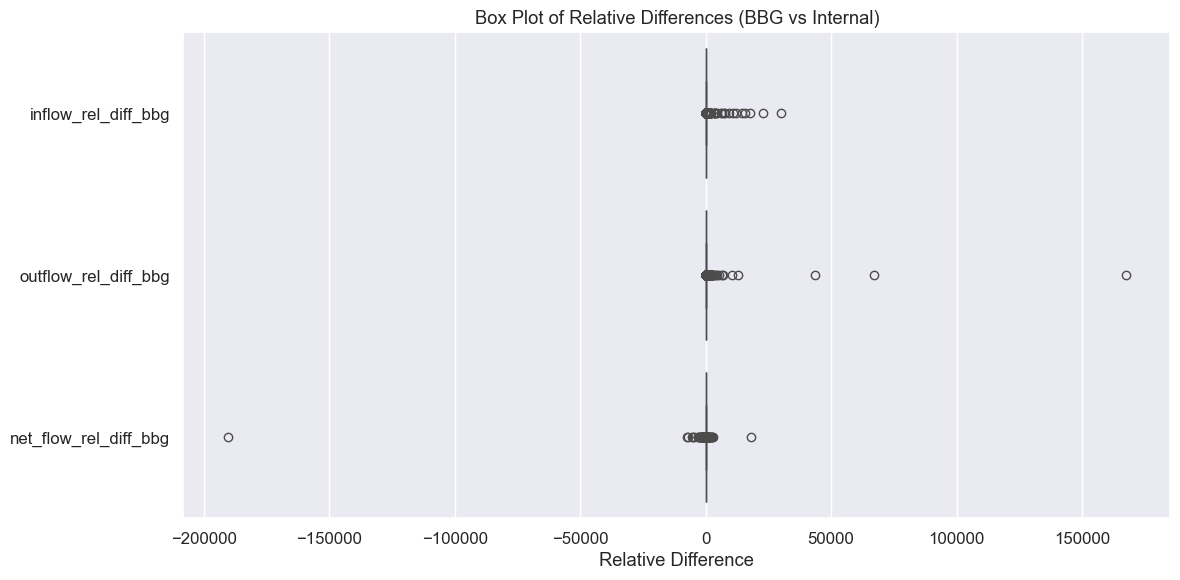

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df.filter(like="rel_diff_bbg"),
    orient="h"
)
plt.title("Box Plot of Relative Differences (BBG vs Internal)")
plt.xlabel("Relative Difference")
plt.tight_layout()
plt.show()

## QQ Plot

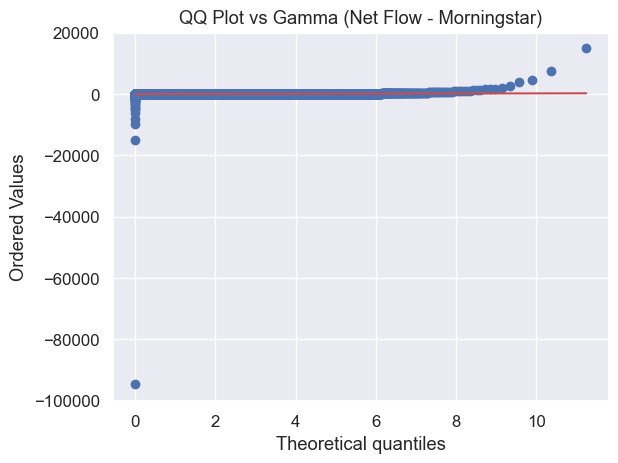

In [70]:
from scipy.stats import probplot
import matplotlib.pyplot as plt

plt.figure()
# Provide shape parameters for the gamma distribution using `sparams`
probplot(merged_df["net_flow_rel_diff_mstar"].dropna(), dist="gamma", sparams=(1,), plot=plt)
plt.title("QQ Plot vs Gamma (Net Flow - Morningstar)")
plt.show()


## ECDF of Relative Differences

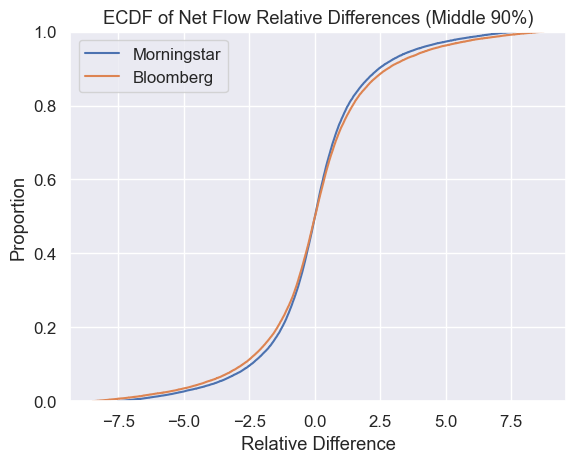

In [72]:
# Filter data to focus on the middle 90%
filtered_mstar = merged_df[(merged_df["net_flow_rel_diff_mstar"] >= merged_df["net_flow_rel_diff_mstar"].quantile(0.05)) & 
                           (merged_df["net_flow_rel_diff_mstar"] <= merged_df["net_flow_rel_diff_mstar"].quantile(0.95))]
filtered_bbg = merged_df[(merged_df["net_flow_rel_diff_bbg"] >= merged_df["net_flow_rel_diff_bbg"].quantile(0.05)) & 
                         (merged_df["net_flow_rel_diff_bbg"] <= merged_df["net_flow_rel_diff_bbg"].quantile(0.95))]

# Plot ECDF for the middle 90%
sns.ecdfplot(data=filtered_mstar, x="net_flow_rel_diff_mstar", label="Morningstar")
sns.ecdfplot(data=filtered_bbg, x="net_flow_rel_diff_bbg", label="Bloomberg")
plt.title("ECDF of Net Flow Relative Differences (Middle 90%)")
plt.xlabel("Relative Difference")
plt.legend()


## Heatmap of Mean Discrepancy by Ticker/Provider

Text(0.5, 1.0, 'Avg Net Flow Discrepancy (Morningstar) by Asset/Provider')

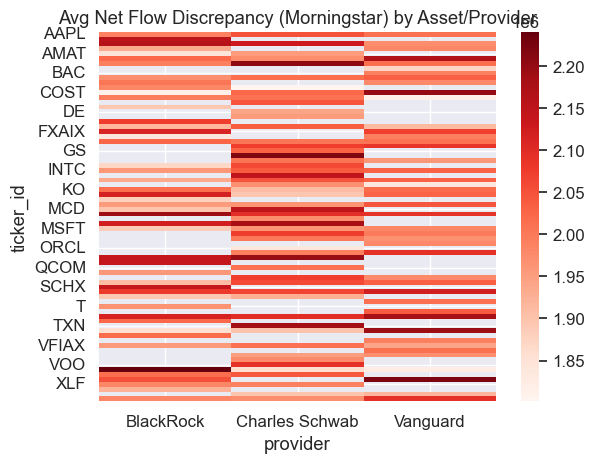

In [73]:
pivot = merged_df.groupby(["ticker_id", "provider"])["net_flow_abs_diff_mstar"].mean().unstack()
sns.heatmap(pivot, cmap="Reds", annot=False)
plt.title("Avg Net Flow Discrepancy (Morningstar) by Asset/Provider")


# Save Merged Data

In [78]:
merged_path = "../data/merged_flow_comparison.csv"
merged_df.to_csv(merged_path, index=False)

merged_path

'../data/merged_flow_comparison.csv'